In [5]:
import os
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import csv
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

In [7]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [8]:
ROOT = '/mnt/data0/lucy/manosphere/'
SUBS = ROOT + 'data/submissions/'
COMS = ROOT + 'data/comments/'
SUB_META = ROOT + 'data/subreddits.txt'
LOGS = ROOT + 'logs/'
PEOPLE_FILE = ROOT + 'data/people.csv'
SUB_META = ROOT + 'data/subreddits.txt'

# Glossary / manual list of people

There is a list of words referring to people (PEOPLE_FILE) manually pulled from online glossaries about manosphere communities. 

In [2]:
def get_manual_people(): 
    """
    get list of words, add plural forms
    copied from find_people.py
    """
    words = set()
    sing2plural = {}
    with open(PEOPLE_FILE, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader: 
            word_sing = row['word (singular)'].strip()
            plural = row['word (plural)'].strip()
            if word_sing != '':
                if word_sing.lower() in words: print('REPEAT', word_sing)
                words.add(word_sing.lower())
                sing2plural[word_sing.lower()] = plural.lower()
            if plural != '': 
                if plural.lower() in words: print('REPEAT', plural)
                assert word_sing != ''
                words.add(plural.lower())
    return words, sing2plural

In [3]:
def get_subreddit_categories(): 
    categories = defaultdict(str)
    categories_rev = defaultdict(list)
    with open(SUB_META, 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            name = row['Subreddit'].strip().lower()
            if name.startswith('/r/'): name = name[3:]
            if name.startswith('r/'): name = name[2:]
            if name.endswith('/'): name = name[:-1]
            categories[name] = row['Category after majority agreement']
            categories_rev[row['Category after majority agreement']].append(name)
    return categories, categories_rev

In [9]:
categories, categories_rev = get_subreddit_categories()

In [10]:
people, sing2plural = get_manual_people()

# NER tagged glossary people

We ran an NER tagger over the entire dataset and got even more mentions of people. We can compared these automatically tagged people with manually obtained glossary words. 

In [14]:
people, sing2plural = get_manual_people()

In [15]:
with open(LOGS + 'gram_counts/tagged_counts_full.json', 'r') as infile: 
    tagged_counts_full = Counter(json.load(infile))

In [16]:
total_gloss_counts = Counter(df_gloss.groupby(['word']).sum().to_dict()['count'])

Get the ratio of tagged counts to full counts for glossary words, and then plot a histogram of these ratio values.  

The assumption here is that words that tend to have many uses as non-people should have a low ratio (below 0.2). However, it seems like the tagger does not catch some glossary words that commonly refer to people. 

In [27]:
gloss_tagged_ratio = Counter()
for term in people: 
    if total_gloss_counts[term] < 500: continue
    tagged_total = sum(tagged_counts_full[term].values())
    ratio = tagged_total / total_gloss_counts[term]
    gloss_tagged_ratio[term] = ratio
for tup in gloss_tagged_ratio.most_common(): 
    if tup[1] < 0.2 and total_gloss_counts[tup[0]] >= 500:
        print(tup[0] + ',' + str(total_gloss_counts[tup[0]]) + ',' + str(tup[1]))

cunts,46151,0.19752551407336785
fag,17606,0.19714869930705442
hb,145441,0.19516504974525753
aspies,4538,0.19259585720581754
cunt,95358,0.19211812328278696
cum dumpster,2378,0.19091673675357443
currycel,6640,0.1891566265060241
wussy,2154,0.18802228412256267
robot,23791,0.18784414274305408
gf,196820,0.18776547098872065
cuckold,13785,0.18745012694958288
neet,16906,0.1872707914349935
retards,22659,0.1851361489915707
tribes,10186,0.1827017474965639
hater,9428,0.18158676283411115
manlet,37181,0.1805492052392351
nigger,17315,0.17805371065550102
orbiters,30031,0.17735007159268756
mangina,20361,0.17646481017631746
wageslave,2505,0.17644710578842315
feminazi,12940,0.17565687789799073
cucks,80899,0.1715843211906204
feminist,535539,0.17083349672012682
bfs,5620,0.16690391459074733
blackcel,2423,0.16673545191910855
conformists,547,0.16453382084095064
cum dumpsters,1123,0.15939447907390916
ricecel,4019,0.15924359293356558
foid,50573,0.15751487948114606
role model,10877,0.15316723361220924
boomer,6226

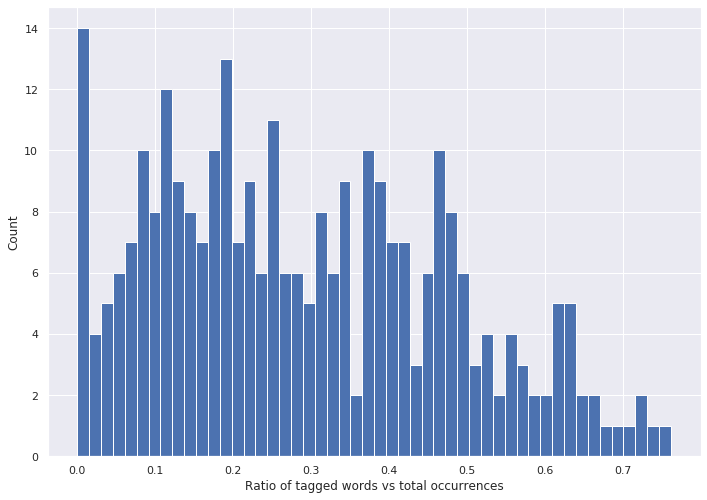

In [18]:
plt.hist(gloss_tagged_ratio.values(), bins=50)
plt.xlabel("Ratio of tagged words vs total occurrences")
plt.ylabel("Count")
plt.show()

Find cases where an entity is not tagged but still occurs in the text

In [83]:
def find_mismatches(w):
    month = '2014-05'
    occurrences = []
    with open(LOGS + 'tagged_people/2014-05', 'r') as infile: 
        i = 0
        for line in infile: 
            content = line.split('\t')
            entities = content[1:]
            for entity in entities: 
                tup = entity.lower().split(' ')
                phrase = ' '.join(tup[4:])
                if phrase == w: 
                    occurrences.append(i)
            i += 1
    j = 0
    with open(COMS + 'RC_' + month + '/part-00000', 'r') as infile:
        i = 0
        for line in infile: 
            d = json.loads(line)
            if w in d['body'].lower() and i not in occurrences: 
                print(d['body'])
                print('----------------')
                j =+ 1
                if j > 20: break
            i += 1

In [84]:
find_mismatches('person')

&gt;But one day after some wine, she is inclined to do it? Is that still violating consent since she disagreed before but now is consenting / offering under intoxication?

I already said - this is not illegal, it's just *fucking shady*.

&gt;But if she actually agreed verbally, how do you know if she's really up for it or just drunk?

Wait until she's more sober, and **ask**.

&gt;Does it mean that as soon as alcohol touches someone's lip, consent goes out the window because even if they verbally agree / offer sex, it can still be rape since the decision was made under intoxication?

If you are incapable of judging how drunk someone is, don't have sex with that person if they've had any alcohol recently. If you're capable of telling the difference between when someone has had a couple drinks but they're fine, and when they should not be allowed to drive, then use your judgement.

You could always talk to someone sober about this and circumvent the whole issue, of course. My boyfriend a

So I will be honest with you, I was in that position as well. I was down and out. What I found to be the biggest help was making guy friends, here's how:

* Pump your self up. I think there was an episode of 30 Rock where Jack says while looking into the mirror, “You’re a tiger.  Take what’s yours.” That's what you need to be. 

* Engage Engage Engage. Go to social gatherings and introduce yourself right away to the nearest person. It will be easier if you do it right away and the more that you second guess yourself the worse off you'll be. 

* Control the conversation, you're the boss or the tiger here. Maintain a flow of the conversation. 

There was a point where I was right there with you, but making guy friends is really helpful. It helps you build a social circle. Trust me you'll get laid or you'll makeout with girls eventually (look at me, I was a dork in high school and for most of college), but having a core group of guy friends will get you through anything.

As always read, 

I do truly hate lazy logic:
&gt;The correct data to use to compare the incidence of rape for women and men is the lifetime statistics

There is no "correct" data to use. The 12-month numbers are included in the lifetime numbers. The purpose of splitting the results is to show the potential rate of sexual violence in the most recent year. The commenter is correct that the rates could vary depending on the selected year (although the smaller subset of respondents should not affect the rate this much). However, we do not have that data. The data we do have shows that men reported a higher rate sexual victimization in 2010 compared to their lifetime experiences. That should raise eyebrows because one would not expect to see such a dramatic difference in the rates. 

&gt; unless you're saying that the rape of children or teenagers shouldn't count
As far as I can tell, the researchers did not count those acts as rape per se. In most states, any sexual intercourse with a child under 12 counts

It's not bad to want to leave, but you don't want to die, you really just want to stop hurting and feeling sad. Pills don't work for everyone. I personally don't blame you for not wanting to go back on them. 

The people around you hold you to a standard they know you are capable of. Sometimes they know it better than ourselves. When we feel so down, even thinking a positive thought about ourselves can make us feel silly. 

Firstly, forget about your friend for now. It is causing you more stress and they may just need time. Try and distract yourself from it. Read, watch something, go for a walk or just browse reddit for a little while :).  The same principle applies to your family. Families can be hotbeds for drama. These things happen and time can fix it. 

It will help you if you stop saying bad things about yourself. Even if you think them, saying them out loud validates them. Do not let these thoughts win. Sit yourself down when you're feeling calm and write the nice things about y

Less about availability and more about adaptability and quality. Though distance does make the heart grow fonder. The thing is that you want to get better as an individual. It's something we value in ourselves. And as the vain monkeys that we are, we like it in other people. To have someone around that is a badass just like you is incredibly motivating. You can learn from them as well as teach them. You grow together and they both feel amazing. Then... sex is amazing. 

It's funny. I just watched Don Jon the other night. It kinda fits here, but it's not really the story for this. Just pick someone that you can learn from. Someone that's a little more than disposable. 

Also, don't put so much pressure on the other person to be attractive to you maybe. Maybe it's partly your responsibility to maintain attraction as well. Maybe.
----------------
Personally, I think a big thing is personality. I've been told I'm an attractive person, and personally I don't think I look that bad. I'm avera

----------------
My friend and I didn't care about her getting mad at us. We told her what we thought, the double standards, men have an "image" to live up to, and that if she just had a non-sexual blank person rather than an obvious female, it would show it as an abuse on both male and female.


----------------
&gt; And I have to admit I might take the small risk and wait until the second or third time before bringing up the contract.

With this as a given option I think the contract is a pretty good idea, because if you're going to do it a 2nd/3rd time chances are you'll have more repeat interactions, as well it would make it so that if you somehow got someone whom intentionally gets pregnant to try to make you be a father (might want to define 'accidental' somewhere in there, since one might argue that if one party had intent to get the woman pregnant it was in no way accidental, regardless as to if the other party was trying to get her pregnant or not), which I personally think is

Sounds like good advice. I'm not trying to hook up with her until next school year, just wanted to become friends.  Asked for her number in a really not smooth way. Sarcasm didn't go too well since it was twitter messaging and we've never talked in person before haha.    Ill post the conversation so you can see the situation better. But basically the girl is really cute and we have a decent amount of mutual friends.  Normally I wouldn't really give a shit if it didn't go well but this girl is actually real cool. 
----------------
I really enjoyed reading that screenshot album, by the way. Not going to lie, it was pretty hilarious. Especially u/GayLubeOil 's stuff. 

You guys are such nerds, you know? Taking everything literally... Why dont you lighten up? Some of the red underlined shit is clearly joking, and nothing more. 

Do you ever visit 4chan? You know how they have their own little lingo that they use? Certain ways of getting points across? That same thing applies to TRP, man. T

I'm just having fun condescending to a stupid and immature person on the internet.

Seriously, you just tried to pull 'at least I'm not a...' when you subscribe to a misogynistic subreddit that advocates women being forced to marry their rapist. How thick could you be?
----------------
"From a google translate of a report about this ad, the ad agency said:

"This is an invitation to dream, to fight for what we want and make our own decisions. It is the cry of women to personal liberation, to pursue their goals and take charge of your life. A very Desigual philosophy that places special emphasis on the figure of the woman, whom he admires and appreciates."

Jesus fuck, are you kidding me? But remember we male shitlords in the developed West live in such an evil, evil patriarchy just utterly rife from top to bottom with nonstop heterohegemonic cis-white supremacist misogynistic ableist patriarchal oppression of wombyn."  --This gem from /u/AndyAndrophile worth sharing here. 

-----------

maybe you're like me, the minute I open my mouth people get disinterested very quickly.  I know there are steps to take when socializing with people, sometimes I skip steps (i.e: get a little too personal too quickly, too serious, jump to subjects without letting it happen naturally ect.)
----------------
Use that inspiration your brother gave you, you can use it most now more than ever. Do something with it - write, read, create, explore. Now is a fitting time to do something, you're quite the opposite of useless, especially at a time like this. Console your family. Console friends. Reflect on the amazing times you had. Reflect on what a great person he was. Talk about how he inspired you. What did he inspire you to do? Keep his spirit alive with laughter, tears, smiles, and stories. I know it's cheesy, but it's true; he would want you to *live* now. He loved you unconditionally, you love him unconditionally, and the best part is that you both knew that. He left this Earth with the kn

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



I've dated feminists and I'm friends with a few as well (skills are similar for dating or friendship). This guy is doing it all wrong.

If she mentions some random feminist silliness, you don't get defensive. You ignore it. Maybe amplify - if a friend of mine discusses rape in the US, I agree with her and discuss rape in India [1]. She can't disagree, yet it makes her complaints sound silly. If she calls me out on something she perceives as sexist, i embrace it. "You know that sounded sexist, right?" "That's how it was intended." Otherwise, just treat it as a cute little quirk of her personality. 

Surprising to hear it, but maintaining frame actually works. 

It also helps if you restrict yourself to the thinking feminists - they do exist, though they are small in number. 

[1] Imagine a place where nearly every complaint US feminists made about "rape culture" and similar things were actually true. Welcome to India. 
----------------
All people lie. you already are on your guard when 

Hi

First of all well done for detoxing off K2
I had to look up K2 as I am not well up on the drugs of today.

You are not the only person who reports addiction and dependency problems with synthetic cannabis.
I wonder, if the makers of this stuff knew how addictive it was, in the same way that they knew how addictive crack was before it hit the streets.

You have a hell of a lot going on in your life.
No wonder you are overwhelmed.

You're not a junkie, or a piece of shit, you just had troubles which is why you used the K2.
You even started it because you did not want to get into trouble with smoking weed.

All drug addicts are really troubled people and they get drawn into bad things. They get swept away.  You did well to pull yourself out of it.

I see you have a son. It must be so painful not seeing him. One day when he is older, may want to know who is real Dad is. 
I hope you don't feel pressured by that, because I know the weight of your pain feels heavier than anything right no

----------------
I agree that is what immigration Canada determined her to be. I don't think that's in dispute. I also agree that they didn't take into account her felony conviction because what she did wasn't a crime in Canada. I agree that such things ought not be taken into account in any event. 

Do I think of her when I think of refugee? No. I don't. But I don't think what she did should stop her from applying for immigration status like a normal person. 
----------------
Is there someone in your life you could talk to, personally? I always valued support groups to see me through tough times. I think it's deplorable for people to make fun if you. But the thing is, these kinds of people do this because they themselves might be going through some tough times and looking for some sort of control. Telling your boss might also help.
----------------
Okay back up. People are in the comments telling you 'you wont lose weight' etc. I have had ED and I know personally those types of commen

But now back to you, what makes you feel that way? Did something happen? Do you want to share? Because you can say whatever you want to that question. You can be honest or you can lie, even though I prefer you to be honest. Tell me a bit about yourself or what made you feel this way. Im a curious person.
----------------
The thing is, I believe "privilege" is a valid concept, but it is grossly twisted and bastardized by most. 

As a tool to understand underprivileged persons or persons born into wealth or persons with genetic or acquired disabilities it can be useful to determine what contributions or consolations a person might need to achieve equality, generally on an individual basis.... Though It doesn't work on an absolute scale...  What about a person born into wealth, with no arms? 

 Using it to attack groups is discrimination, one may argue that as a tool it is as well, however I think it is a mental philosophical tool that can help understand people in disparate situations 
-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Protip: You never know if you're attractive to a girl unless you try. 

Bonus protip: Attractiveness isn't always physical.

Sorry, it's just stuff like this really makes me feel sad for every guy (and girl) out there that thinks themselves to be unattractive - because what is unattractive is a guy that's too scared to put himself out there, that's too closed off from the rest of the world that he is standoffish.  What is unattractive is a guy that thinks he's a the best thing since sliced bread because he's physically attractive and acts like a cocky douche.  

EVERY person can be attractive, and IS attractive to someone.  But having an attitude that suggests you can predict how another person will see you is exactly the perfect way to never succeed. 

Edit: them damn words again.
----------------
Well, here's the thing. There is Feminism and then there are feminists.

Most feminists, in my view, are decent people. There are loud exceptions, of course, but I think the average person w

What's funny is there was also one comparing black and white person theft, and SJW's got up in arms about how our society views a white person stealing versus a black person stealing. Yet somehow they fail to see the sexism here. In fact most of the racial issues they get upset about (discrimination in the justice system, lack of empathy for black victims of violence, black people being left behind in our educational system, etc) are significant men's rights issues that SJW's ignore or even flat out deny.
----------------
How about "I haven't dated too much" followed by a quality not a quantity question like "What are you looking for in a guy/girl?" It steers the conversation in a way where you will hopefully feel comfortable giving input if the person reciprocates the question to you.

Ideally, if you end with a question it's less likely that they're going to probe deeper into your response. However if you just answer with the statement, it's easier for the person to ask a deeper ques

----------------
Seriously, being in a relationship and having sex does not make you any more of a person. There's a lot of good wisdom you've received so far in other comments. but when I was in your shoes I literally told the world and the ridiculous pressure society puts on us to be good looking and sexy to go fuck themselves. I actually got angry enough to out my foot down and try to be happy as me, and no one else. Some days are harder than others but overall it was a relief to let go of that pressure.
----------------
You get past it with small steps. If you want to be the type of person you love talking to, you need to try, even if it seems hard. Don't be afraid to fail. I know it seems like it would be embarrassing, or like they won't want to talk to you, but you really don't have a way of knowing that - you're unconsciously trying too hard to protect yourself.

So start asking the questions back. You don't need to strike up conversations with strangers out of the blue yet, bec

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



&gt;He also appears to lack empathy toward all people. **It's not surprising that he's a misogynist.** I couldn't find a single word in his manifesto describing another person's feelings. When he talks about killing, he only talks about how he would feel when killing, not about how the victim would feel.

Right he is a misogynist. Like I was saying. We're going to a lot of great lengths here to get to the idea that he's not only a misogynist, which I never claimed. Simply that he was misogynist who hated women for refusing him. It's a very simple point that you even agree with to an extent but for some reason feel compelled to argue about.

&gt;People keep saying that he felt entitled to have a girlfriend. They intentionally omit the fact that he also felt entitled to win the lottery. From his manifesto:

I don't think there's a reason to presume intent here.

&gt;In my last comment, I said this does not fit into the misogyny narrative at all. How does this have anything to do with mis

What MRA's talk about "friend zones"? Is there a single name to an MRA that one could say right now and provide an example of when they uttered any reference to the subject?

Somehow these ideas propagate into the mainstream. I want to know what quote or what random person these people could possibly be referring to that feminists in mass believe it to be true.

It is so wildly outside of the scope of any men's rights position that it is literally laughable. I guess i will just never understand this, or maybe i do. It is just jaded brainwashed morons creating fantasies and grasping at air, as the public at large more and more ignores them. 
----------------
I think what helps me feel better about my physical appearance is going to walmart. Seriously. Go to walmart and play the,'Thank God I'm not that person' game. There is always someone who would switch bodies with you in an instant. You are very tall, so that's a definite plus. But not all women are shallow. Although I know you didn'

This is beautiful advice. To add, if you don't have time to volunteer or it really is too much at first, go to a pet store where you can play with the animals. Socializing an animal that is stuck in a cage all day does absolute wonders for their health, and will give them a better chance of being adopted. Personally, I like to hang out with parrots because a lot of people are afraid of birds or don't know how to handle them and will just avoid them. They are incredibly social creatures (some have the intelligence of toddlers!) and they can get extremely depressed. I've met a bird that was so distressed from loneliness that he would scratch his neck until it bled. 

Seriously though, I have never been happier in my whole entire life than when I make someone smile or improve an animal's life. 
----------------
Do you recall how long ago that was?  The PMs we are seeing now are different, but we had a rash of those detailed methods messages I think a couple of years ago.

In any case I'm 

----------------
Of course not. Terpderps ignore personality in lieu of a simple fuckhole. Your status as a human being with coherent thought and emotion guarantees no extended contact with the primitive Red Pill species.
----------------
Thanks for the gold person..
----------------
This made me realise just how much I inadvertently depend on my sister. 
She can be the only person I have conversations with, sometimes for whole weeks at a time.
----------------
alphas do not have "superior" genes, just like men are not "superior" to women.

alphas, particularly by the way (young and fertile) women judge a man to be alpha, is by judging traits such as high aggressiveness, muscularity, etc. all high T levels. 

if every man tries hard to be the alpha male of the group and risks his life to become one, the country will soon look like somalia, where the weak die and the strong survive.

the truth is, we are NOT heading towards a new equilibrium of "harems" as you imply. it looks like this 

&gt;I can assure you I'll remain calm and reasonable as long as you don't outright attack me on a personal level :D

Sigh, typical.
----------------
I know you 17-year-olds are the easy-fuck Tinder generation, but you still have to do a *little* bit of comfort building before jumping into sex talk, then asking for personal contact information so you can send the girl more sex talk in the future.

Right out of a shitty PUA handbook: Build attraction (you maybe had an initial spark, but didn't build it), build comfort (you didn't), escalate (you didn't), close (you went for a #-close).

Here's a translation with your clown antics removed:

M: "Sex!"

F: "Huh?"

M: "Gimme # for later sex!"

F: "Uhh."

M: "J/k. Well not really."

F: "Let's change subjects."

M: "No! # for later sex!"

F: "No. Scram."
----------------
&gt;How do you keep a balance? 

By looking at reality as it is and not as a collection of ideas or guidelines for you to follow. Red Pill when done as a opposite of blue pill

It's not a reflection of slut shaming. A lot of women don't like men who have banged a lot of women either. It's more about that person not looking like they're into monogamy. It can also have to do with the person's feelings of inadequacy about being compared to others in the bedroom.
----------------
Start small. Sounds like your job isn't helping; maybe stop looking for a relationship and start looking for a new job?

When you get that new job, start trying new things: sounds like you may surround yourself with people who lower your worth: girl started dating one of your best friends, and the friend was OK with that? And this girl? She sounds like trash. Your social circle contains someone who thinks you're a liar? They can go fuck themselves.

Lastly, you've probably heard this a million times, but confidence is key. I hate to say it, but all the shit you've been through will make you a stronger, more understanding, versatile person. It sucks, but it just takes time. Get rid of wha

## Annotated vocabulary

In [134]:
ANN_FILE = ROOT + 'data/ann_sig_entities.csv'
UD = LOGS + 'urban_dict.csv'

The cells below do the following "sanity checks": 
- examine common prefixes and suffixes to bigrams
- check cases where I marked Y but the people occur more often as proper nouns 
- check cases where I marked N but the people have "a" or "an" as a determiner (to avoid missing a proper name that represents a persona)
- check that plural and singular forms of a word are consistently labeled Y. If not, there should be a good reason why (e.g. semantic ambiguity for one form of the word)
- see if spreadsheet words in urban dictionary or wordnet

In [138]:
prefixes = Counter()
suffixes = Counter()
vocab = set()
all_entities = set()
questionable = set()
with open(ANN_FILE, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader: 
            all_entities.add(row['entity'])
            if row['keep'] not in set(['Y', 'N', 'Q']): 
                print(row)
            if row['keep'] == 'Q': 
                questionable.add(row['entity'])
            if row['keep'] == 'Y': 
                vocab.add(row['entity'])
                if row['labels'] != '':
                    labels = json.loads(row['labels'])
                    if 'prop_per' in labels and 'nom_per' in labels: 
                        if labels['prop_per'] > labels['nom_per']: 
                            print('Y PROPER', row['entity'])
            if row['keep'] == 'N': 
                if row['det / poss '] != '':
                    dets = json.loads(row['det / poss '])
                    if 'a' in dets and dets['a'] > 100: 
                        print('N DET', row['entity'])
                    if 'an' in dets and dets['an'] > 100: 
                        print('N DET', row['entity'])
            if row['ngram'] == 'bigram' and row['keep'] == 'Y': 
                contents = row['entity'].split(' ')
                if len(contents) < 2: 
                    print(row)
                prefixes[contents[0]] += 1
                suffixes[contents[1]] += 1
print()
print(prefixes.most_common(30))
print()
print(suffixes.most_common(30))

Y PROPER mgtow
Y PROPER chad
N DET sub
Y PROPER op
N DET judge
N DET bot
Y PROPER chads
Y PROPER sjw
Y PROPER hb8
Y PROPER stacy
Y PROPER hb9
N DET john
Y PROPER hb7
N DET mm
N DET friendzone
Y PROPER tyrone
Y PROPER mgtows
N DET brad
Y PROPER christians
Y PROPER hb6
N DET junior
Y PROPER stacies
Y PROPER europeans
Y PROPER chadlite
N DET strawman
N DET fetus
Y PROPER germans
Y PROPER noone
Y PROPER jb
Y PROPER gangbanger
N DET pokemon
N DET principal
Y PROPER stacey
Y PROPER becky
N DET brotherhood
N DET superman
Y PROPER norman
Y PROPER antifa
Y PROPER hb5
N DET pope
N DET leo
Y PROPER romans
Y PROPER canadians
Y PROPER tyrones
Y PROPER chang
Y PROPER brits
Y PROPER turks
Y PROPER jbs
Y PROPER stacys
Y PROPER wymyn
N DET ug
Y PROPER casanova
N DET dwarf
N DET kardashian
Y PROPER swedes
Y PROPER amish
N DET hobbit
N DET chimp
N DET baker
Y PROPER whitey
N DET mason
Y PROPER slavs
Y PROPER hb4
Y PROPER soviets
Y PROPER adonis
Y PROPER staceys
N DET sith
Y PROPER dh
N DET 3some
Y PROPER

In [127]:
# this uses a naive form of checking plurality (e.g. using 's' endings)
with open(ANN_FILE, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader: 
            if row['keep'] == 'Y': 
                if row['entity'].endswith('s'): 
                    if row['entity'][:-1] in all_entities and row['entity'][:-1] not in vocab: 
                        print(row['entity'])
                elif row['entity'] + 's' in all_entities and row['entity'] + 's' not in vocab: 
                    print(row['entity'])

judges
naturals
johns
swimmer
masons
finns
danes
retailer
apostle
juniors
victors
kiwis
one girl
one person
other sub
black panther
you friends
fucking kid
you brothers
own sons
new yorkers
meek


See how many of the words in our list are in Urban Dictionary and WordNet: 

In [129]:
from nltk.corpus import wordnet as wn

In [132]:
def get_dict_coverage_vocab():
    num_definitions = Counter()
    with open(UD, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('|')
            word = contents[0].lower()
            if word in vocab: 
                num_definitions[word] += 1
    missing_count = 0
    for w in vocab: 
        if num_definitions[w] == 0: 
            missing_count += 1
    print("TOTAL:", len(vocab))
    print("MISSING:", missing_count)
    print("IN URBAN DICT:", len(num_definitions))
    print("PERCENT MISSING:", missing_count / len(vocab))
    print(num_definitions.keys())
    print()
    missing_count = 0
    found = set()
    for w in vocab: 
        if len(wn.synsets(w)) == 0: 
            missing_count += 1
        else: 
            found.add(w)
    print("MISSING:", missing_count)
    print("IN WORDNET:", len(found))
    print("PERCENT MISSING:", missing_count / len(vocab))
    print(found)

In [133]:
get_dict_coverage_vocab()

TOTAL: 6620
MISSING: 6555
IN URBAN DICT: 65
PERCENT MISSING: 0.9901812688821753
dict_keys(['chad', 'bf', 'afc', 'bro', 'bfs', 'chang', 'chode', 'alpha', 'cougar', 'aspie', 'cuckold', 'beta', 'cuck', 'becky', 'chadpreet', 'betas', 'currycel', 'cheater', 'casanova', 'bunny', 'amog', 'gf', 'hb', 'fho', 'hbs', 'gfs', 'hb10', 'jock', 'gymcel', 'feminazi', 'foid', 'femcel', 'femoid', 'khhv', 'gamers', 'landwhale', 'gamma', 'incel', 'mra', 'pua', 'mangina', 'normies', 'normie', 'manlet', 'omega', 'otaku', 'orbiter', 'meek', 'neet', 'roastie', 'ricecel', 'noodlewhore', 'mgtow', 'slayer', 'simp', 'sjws', 'tradthot', 'stacy', 'volcel', 'zeta', 'truecel', 'tyrone', 'wizard', 'unicorn', 'target'])

MISSING: 4701
IN WORDNET: 1919
PERCENT MISSING: 0.7101208459214502
{'libertarians', 'nutters', 'ancestor', 'guest', 'hostages', 'driver', 'crook', 'speaker', 'lawmaker', 'catholics', 'buffoon', 'bridesmaid', 'contractor', 'indians', 'newbies', 'cheaters', 'prophets', 'shrinks', 'antagonists', 'ex', 'com